In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
import os
from tqdm.notebook import tqdm
import pickle
from sklearn.model_selection import train_test_split

In [2]:
DATASET_PATH = './genres'
FEATURES_PATH = f'{DATASET_PATH}/features.pkl'

In [3]:
genres = [path for path in os.listdir(DATASET_PATH) if '.' not in path]
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [4]:
genre_to_num = {genre: i for i, genre in enumerate(genres)}
genre_to_num

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [5]:
num_to_genre = dict(enumerate(genres))
num_to_genre

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

### create features

In [6]:
import librosa

In [16]:
def get_mfcc(wav_name, max_len=1200): # 2895):
#     rate, sig = wav.read(wav_name)
#     mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy = False)
    rate = 22050
    sig, rate = librosa.load(wav_name, sr=rate)
    mfcc_feat = librosa.feature.mfcc(sig, rate, n_mfcc=13, n_fft=512, hop_length=512).T
#     covariance = np.cov(np.matrix.transpose(mfcc_feat))
#     mean_matrix = mfcc_feat.mean(0)
#     feature = (mean_matrix , covariance , 0)
    return mfcc_feat[:max_len]

In [94]:
genre_folders = [path for path in os.listdir(DATASET_PATH) if '.' not in path]
for genre_name in tqdm(genre_folders[4:5]):
    wavs_list = os.listdir(f'{DATASET_PATH}/{genre_name}')
    for w in wavs_list[:1]:
        wav_path = f'{DATASET_PATH}/{genre_name}/{w}'
        mfcc_feat = get_mfcc(wav_path)
mfcc_feat.mean(axis=0).shape

(13,)

In [84]:
import librosa.display

In [92]:
mfcc_feat.T.shape

(13, 1200)

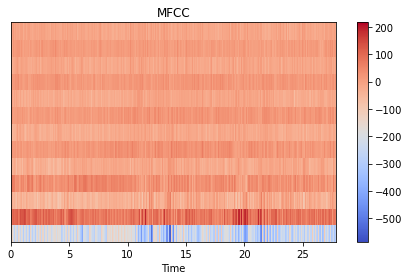

In [95]:
librosa.display.specshow(mfcc_feat.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

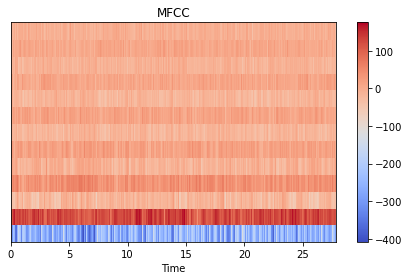

In [93]:
librosa.display.specshow(mfcc_feat.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

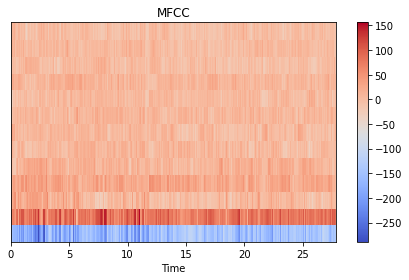

In [90]:
librosa.display.specshow(mfcc_feat.T, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [18]:
def create_save_features(dataset_path: str, out_dir: str):
    data = {}
    data['mfcc'] = []
    data['label'] = []
    """ gets list of folders cotaining wavs and returns created mfcc features and label's csv"""
    genre_folders = [path for path in os.listdir(dataset_path) if '.' not in path]
    for genre_name in tqdm(genre_folders):
        wavs_list = os.listdir(f'{dataset_path}/{genre_name}')
        for wav in tqdm(wavs_list):
            wav_path = f'{dataset_path}/{genre_name}/{wav}'
            data['mfcc'].append(get_mfcc(wav_path).T)
            data['label'].append(genre_to_num[genre_name])
            
    with open(out_dir, 'wb') as f:
        pickle.dump(data, f)

In [19]:
create_save_features(DATASET_PATH, FEATURES_PATH)

### loading data

In [20]:
#  with open(FEATURES_PATH, "rb") as f:
#     data = pickle.load(f)
# set([it.shape for it in data['mfcc']])

In [21]:
def load_data(data_path):
    with open(data_path, "rb") as f:
        data = pickle.load(f)

    X = np.stack(data["mfcc"], axis=0)
    y = np.array(data["label"])
    return X, y

In [231]:
def ttf_split(data, test_size, val_size, seed=4321):
    X_train, X_test, y_train, y_test = train_test_split(*data, test_size=test_size, random_state=seed)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=val_size, random_state=seed)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [232]:
X, y = load_data(FEATURES_PATH)
X.shape, y.shape



((1000, 13, 1200), (1000,))

In [233]:
X, y =  more_samples(X, y)

In [234]:
# create one hot encoding
y_hot = np.eye(y.max()+1)[y]
y_hot.shape

(8000, 10)

### Try LSTM

In [235]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [236]:
from tensorflow.keras.layers import *

In [261]:
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()
    
    model.add(keras.layers.LayerNormalization(axis=1, input_shape=input_shape,))

    # 2 LSTM layers
    model.add(keras.layers.LSTM(128, return_sequences=True))
    model.add(keras.layers.LSTM(128))

    # dense layer
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.7))
#     model.add(keras.layers.BatchNormalization())
    
#     model.add(keras.layers.Dense(32, activation='relu'))
#     model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


# def build_model(input_shape):

#     # build network topology
#     model = keras.Sequential()
#     model.add(keras.layers.LayerNormalization(axis=1, input_shape=input_shape,))

#     # New model
#     model.add(Conv2D(128, 9, padding='same'))  # X_train.shape[1] = No. of Columns
#     model.add(Activation('relu'))
#     model.add(Conv2D(128, 9, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.25))
#     model.add(MaxPooling2D(pool_size=(7)))
#     model.add(Conv2D(64, 5, padding='same'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, 5, padding='same'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, 3, padding='same'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.25))
# #     model.add(MaxPooling2D(pool_size=(7)))
# #     model.add(Conv2D(32, 7, padding='same'))
# #     model.add(Activation('relu'))
# #     model.add(Conv2D(32, 7, padding='same'))
# #     model.add(Activation('relu'))
#     model.add(Flatten())
#     model.add(Dense(256)) 
#     model.add(Activation('selu'))
#     model.add(Dense(10)) # Target class number
#     model.add(Activation('softmax'))

#     return model


In [262]:
def more_samples(x, y, div=150):
    length = 1200 // div
    xs = np.concatenate([x[:,:,i*div:(i+1)*div] for i in range(length)], axis=0)
    ys = np.concatenate([y] * length, axis=0)
    return xs, ys

In [263]:
X = X.reshape([*X.shape, 1])

In [264]:
test_size = 0.25 
val_size = 0.2 
X_train, X_val, X_test, y_train, y_val, y_test = ttf_split((X, y_hot), test_size, val_size)

# X_train, y_train =  more_samples(X_train, y_train)
# X_val, y_val =  more_samples(X_val, y_val)
# X_test, y_test =  more_samples(X_test, y_test)

In [265]:
X_train.shape

(4800, 13, 150, 1)

In [266]:
# input_shape = (X_train.shape[1], X_train.shape[2], 1) # 1200, 13
input_shape = (X_train.shape[1], X_train.shape[2]) # 1200, 13
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.001)
# optimiser = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_23 (Laye (None, 13, 150)           26        
_________________________________________________________________
lstm_9 (LSTM)                (None, 13, 128)           142848    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                1290      
Total params: 292,260
Trainable params: 292,260
Non-trainable params: 0
_______________________________________________

In [267]:
y_val.sum(axis=0)

array([119., 112., 117., 121., 116., 121., 131., 115., 119., 129.])

In [268]:
y_train.sum(axis=0)

array([470., 488., 501., 475., 475., 505., 464., 477., 487., 458.])

In [269]:
# # train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=100)

Epoch 1/100
75/75 [==============================] - 3s 19ms/step - loss: 2.2555 - accuracy: 0.1292 - val_loss: 2.0321 - val_accuracy: 0.2592
Epoch 2/100
75/75 [==============================] - 1s 12ms/step - loss: 2.0296 - accuracy: 0.2486 - val_loss: 1.8280 - val_accuracy: 0.3283
Epoch 3/100
75/75 [==============================] - 1s 11ms/step - loss: 1.8918 - accuracy: 0.3166 - val_loss: 1.7409 - val_accuracy: 0.3717
Epoch 4/100
75/75 [==============================] - 1s 11ms/step - loss: 1.7951 - accuracy: 0.3634 - val_loss: 1.7611 - val_accuracy: 0.3533
Epoch 5/100
75/75 [==============================] - 1s 11ms/step - loss: 1.7428 - accuracy: 0.3626 - val_loss: 1.6487 - val_accuracy: 0.4017
Epoch 6/100
75/75 [==============================] - 1s 13ms/step - loss: 1.6724 - accuracy: 0.4023 - val_loss: 1.6360 - val_accuracy: 0.3983
Epoch 7/100
75/75 [==============================] - 1s 12ms/step - loss: 1.6547 - accuracy: 0.4030 - val_loss: 1.6010 - val_accuracy: 0.4342
Epoch 

75/75 [==============================] - 1s 11ms/step - loss: 0.0538 - accuracy: 0.9842 - val_loss: 3.5682 - val_accuracy: 0.5508
Epoch 59/100
75/75 [==============================] - 1s 11ms/step - loss: 0.1407 - accuracy: 0.9586 - val_loss: 3.4403 - val_accuracy: 0.5358
Epoch 60/100
75/75 [==============================] - 1s 12ms/step - loss: 0.1117 - accuracy: 0.9692 - val_loss: 3.5376 - val_accuracy: 0.5400
Epoch 61/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0695 - accuracy: 0.9820 - val_loss: 3.4728 - val_accuracy: 0.5517
Epoch 62/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0575 - accuracy: 0.9853 - val_loss: 3.6549 - val_accuracy: 0.5533
Epoch 63/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0669 - accuracy: 0.9788 - val_loss: 3.9875 - val_accuracy: 0.5333
Epoch 64/100
75/75 [==============================] - 1s 12ms/step - loss: 0.1798 - accuracy: 0.9504 - val_loss: 3.4475 - val_accuracy: 0.5433
Epoch 65/100

KeyboardInterrupt: 

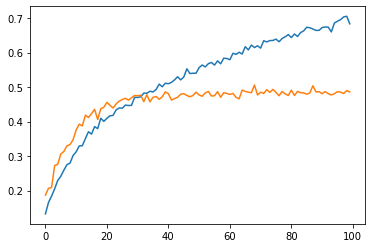

In [270]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [271]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

In [273]:
print(classification_report(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       211
           1       0.85      0.84      0.85       200
           2       0.43      0.46      0.44       182
           3       0.41      0.38      0.39       204
           4       0.56      0.47      0.51       209
           5       0.48      0.66      0.56       174
           6       0.79      0.81      0.80       205
           7       0.70      0.66      0.68       208
           8       0.52      0.51      0.51       194
           9       0.36      0.37      0.36       213

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.58      0.57      0.57      2000



In [278]:
print(classification_report(y_train.argmax(axis=1), model.predict(X_train).argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       470
           1       1.00      1.00      1.00       488
           2       1.00      1.00      1.00       501
           3       1.00      1.00      1.00       475
           4       1.00      1.00      1.00       475
           5       1.00      1.00      1.00       505
           6       1.00      0.99      1.00       464
           7       1.00      1.00      1.00       477
           8       1.00      1.00      1.00       487
           9       0.99      1.00      1.00       458

    accuracy                           1.00      4800
   macro avg       1.00      1.00      1.00      4800
weighted avg       1.00      1.00      1.00      4800



In [275]:
y_test.sum(axis=0)

array([211., 200., 182., 204., 209., 174., 205., 208., 194., 213.])

In [276]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

63/63 - 0s - loss: 4.3761 - accuracy: 0.5715

Test accuracy: 0.5715000033378601
